Many-Body Chern Number without Integration

Koji Kudo, Haruki Watanabe, Toshikaze Kariyado, and Yasuhiro Hatsugai

Phys. Rev. Lett. 122, 146601 – Published 9 April 2019

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.146601

In [289]:
using QuantumOptics
using NBInclude
using Einsum
using DataFrames
using LinearAlgebra
# lattice
@nbinclude("Lattice_Basis_Neighbors_Hops.ipynb"; regex=r"#.*executeme")
# mb tools
@nbinclude("QOJulia_utils.ipynb")
# chern 
@nbinclude("Chern_utils.ipynb")

calc_all_states_H_mb_2 (generic function with 1 method)

# Parameters

In [296]:
param_dict=Dict{}()

LL = [3,3]
N = LL[1]*LL[2]
vv_lattice = [ [1., 0], [0, 1.] ]
b1=[0, 0]
vv_basis = [b1]
param_dict["N"] = LL[1]*LL[2]

param_dict["LL"] = LL
param_dict["vv_lattice"] = vv_lattice
param_dict["vv_basis"] = vv_basis

nb = 1 # number of basis
t=-1 # hopping amplitude
p=1
q=3
ϕ=p/q # magnetic flux per plaquet
param_dict["gauge"] = "Landau"
param_dict["t"]=t
param_dict["ϕ"]=ϕ
θθ = [0, 0] # initial values for twist angles
param_dict["θθ"]=θθ

sites, site_coord, site_number = get_sites(LL, vv_lattice, vv_basis);
param_dict["sites"] = sites
param_dict["site_coord"] = site_coord
param_dict["site_number"] = site_number

pbc=true # periodic boundary condition
param_dict["pbc"] = pbc
neighbors = [ [1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]  ]
neighbors_list = [ neighbors ]
param_dict["neighbors_list"] = neighbors_list

# size of parameter space
N1 = 2
N2 = 2
dx=2*pi/N1
dy=dx
Tx=collect(range(start=0, stop=2*pi-dx, step=dx))
Ty=collect(range(start=0, stop=2*pi-dy, step=dy));

param_dict["Tx"] = Tx
param_dict["Ty"] = Ty;

# 1) Single Particle

In [297]:
basis = NLevelBasis(N) 
param_dict["basis"] = basis;

param_dict["model_H1"] = get_Hofstadter_hamiltonian

H_T = get_Hofstadter_hamiltonian(param_dict)
H1 = get_sp_op(basis, H_T)

EE, UU = eigenstates(dense(H1));

## 1.1) Single Particle Chern

In [298]:
param_dict["param_1"] = "Tx"
param_dict["param_2"] = "Ty"
EEA_0, UUA_0 = calc_all_states_H1(param_dict);

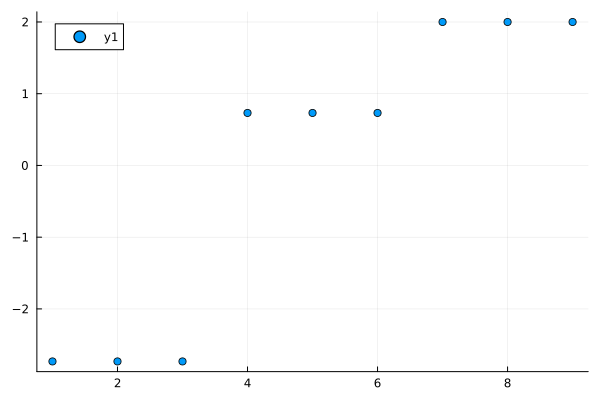

In [299]:
using Plots
scatter(real(EEA_0[1,1,:]))

In [300]:
bands = [[1,4]]
#bands = [[1,3],[4,6],[7,9]]
#bands = [[1,5],[6,10],[11,15],[16,20],[21,25]] # 5x5
Chern, F12list = calc_chern_bands(UUA_0, bands)
Chern

1-element Vector{Any}:
 -6.6261555863823264e-18 + 7.978995685268721e-17im

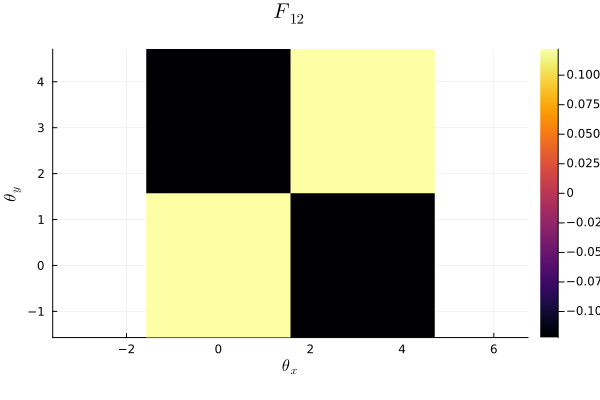

In [301]:
using LaTeXStrings
band_idx = 1
heatmap(Tx, Ty, imag(F12list[band_idx]), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)

# 2) Projected Single Particle

In [302]:
param_dict["sub_range"] = 1:3

sub_states = get_subset_states(H1, param_dict["sub_range"]);
subspace_proj, P, Pt = get_projector_op(basis, sub_states);
H1_proj = get_subspace_op(H1, P, Pt);
#param_dict["subspace_proj"] = subspace_proj
#param_dict["projection"] = subspace_proj, P, Pt;

## 2.1) Projected Single Particle Chern

In [303]:
EEA, UUA = calc_all_states_H1(param_dict);

In [306]:
bands = [[1,3]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

1-element Vector{Any}:
 -7.067899292141149e-17 + 1.7669748230352896e-17im

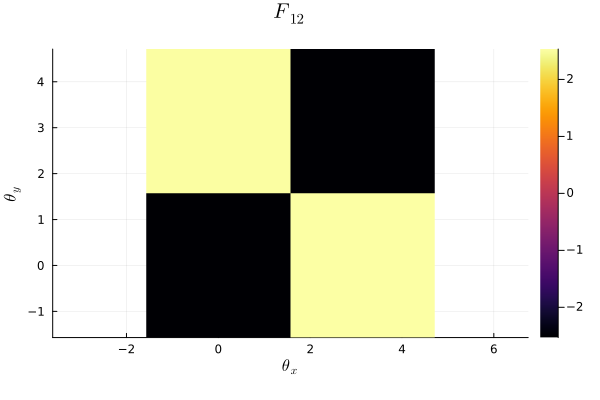

In [307]:
heatmap(Tx, Ty, imag(F12list), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)

# 3) Many Body

In [308]:
delete!(param_dict, "sub_range");

In [309]:
PN = 2
param_dict["PN"] = PN
basis_mb = get_basis_mb(param_dict)

ManyBody(onebodybasis=NLevel(N=9), states:45)

## 3.1) Non-Interacting Many Body

In [310]:
H1_mb = get_mb_op(basis_mb, H1);

In [311]:
param_dict["dimH_mb"] = length(basis_mb)
EEA, UUA = calc_all_states_H_mb(param_dict);

In [312]:
H_mb = get_H_mb(param_dict);

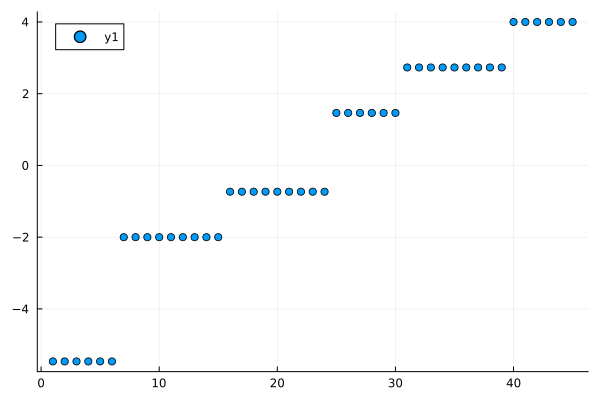

In [313]:
scatter(real(EEA[1,1,:]))

### 3.1.1) Non-Interacting Many Body Chern

In [314]:
bands = [[1,6], [7,15], [16,24], [25,30], [31,39], [40,45]]
#bands = [[1,5], [6,10], [11,15], [16,20], [21,25]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

6-element Vector{Any}:
                    0.0 + 3.313077793191179e-18im
                    0.0 - 4.417437057588194e-18im
 -5.300924469105861e-17 + 3.092205940311753e-17im
  3.533949646070574e-17 + 3.0922059403117533e-17im
 -7.067899292141149e-17 + 1.7669748230352902e-17im
                    0.0 - 3.3130777931911617e-17im

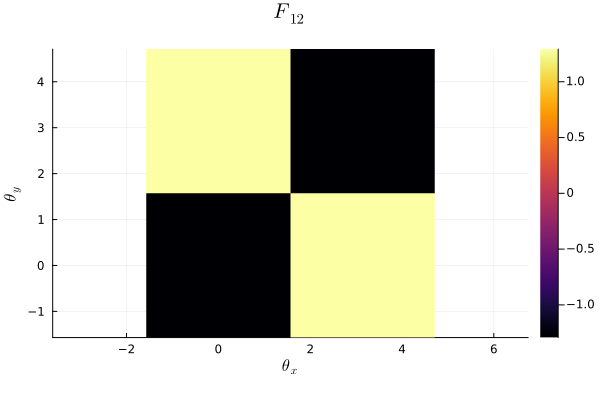

In [315]:
heatmap(Tx,Ty,imag(F12list[4]), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)
# Ortadaki bantlar için F düzgün değil!

## 3.2) Interacting Many Body

In [316]:
delete!(param_dict, "sub_range");

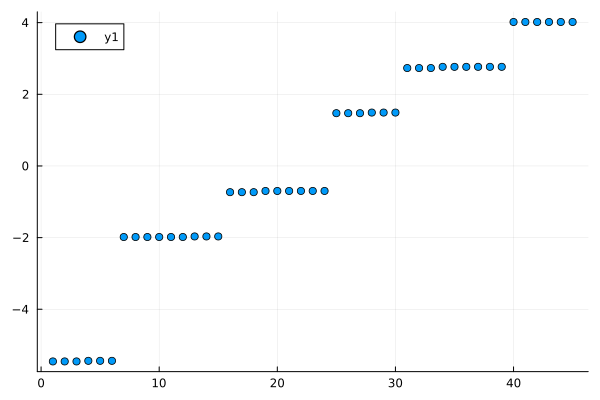

In [320]:
param_dict["U"] = 0.1 # U=0 iken yukarıda ki ile aynı
H_Finite, H_Int = get_Finite_U(param_dict)
#param_dict["θθ"]=[ Tx[2], Ty[2] ]
#Ee, Uu = eigenenergies(dense(H_Finite)) ## Hofstadter MB in Julia.ipynb ile farklı!
EEA, UUA = calc_all_states_H_mb_Finite_U(param_dict)
scatter(real(EEA[1,1,:]))

In [321]:
EEA[1,1,:]

45-element Vector{Float64}:
 -5.45590962889131
 -5.455909628891301
 -5.4559096288913
 -5.439395563425294
 -5.439395563425285
 -5.439395563425277
 -1.9838855584944572
 -1.9838855584944481
 -1.9838855584944446
 -1.9834177223674778
 -1.98341772236747
 -1.9834177223674643
 -1.9677648359962348
  ⋮
  2.7653654873699245
  2.765365487369925
  2.7653654873699254
  2.765944172342553
  2.7659441723425537
  2.765944172342556
  4.01701479831536
  4.017014798315361
  4.017014798315363
  4.017264117643734
  4.017264117643735
  4.017264117643736

### 3.2.1) Interacting Many Body Chern

In [260]:
#bands = [[1,6], [7,15], [16,24], [25,30], [31,39], [40,45]]
bands = [[1,5]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

1-element Vector{Any}:
 -3.9999999999999996 + 2.370674697336849e-16im

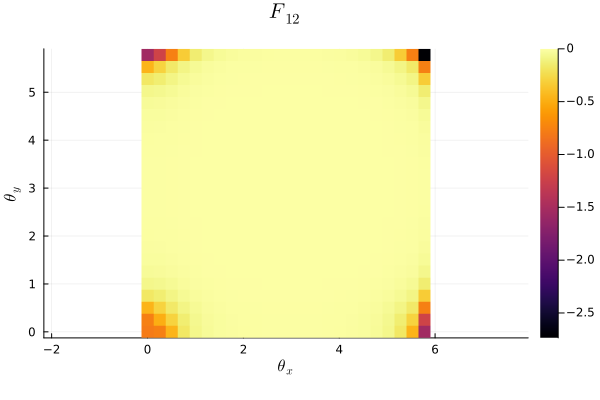

In [261]:
heatmap(Tx,Ty,imag(F12list[1]), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)

# 4) Projected Interacting Many Body

In [25]:
param_dict["sub_range"] = 1:5;

In [27]:
param_dict["θθ"] = [0, 0]
param_dict["PN_int"] = [0, 1, 2, 3]
cut_off = last(param_dict["sub_range"])
param_dict["U"] = 2
H_Total_Intt, basis_cut_mb = proj_MB_Int(param_dict);

In [28]:
EeE, UuU = eigenstates(dense((H_Total_Intt+H_Total_Intt')/2))
UuU_square = eigvecs(dense((H_Total_Intt+H_Total_Intt')/2).data)
EeE

120-element Vector{Float64}:
 -10.259907960459051
 -10.259880060067966
 -10.259880060067962
 -10.259817383274132
 -10.259817383274129
 -10.25976713519965
 -10.259767135199647
 -10.188265733166313
 -10.18826573316631
 -10.188235064904305
 -10.1882350649043
 -10.188192451307165
 -10.188192451307161
   ⋮
  -6.734723793133393
  -6.734545991951682
  -6.734545991951672
  -6.734466900612411
  -3.420053641408167
  -3.420039206750099
  -3.420039206750096
  -3.4200067675417145
  -3.420006767541711
  -3.4199807484885367
  -3.4199807484885327
   0.0

In [29]:
pn = 1
df = get_energies(pn, EeE, UuU, basis_cut_mb)
filtered_energies = Matrix(df)[:,2]

7-element Vector{Float64}:
 -3.420053641408167
 -3.420039206750099
 -3.420039206750096
 -3.4200067675417145
 -3.420006767541711
 -3.4199807484885367
 -3.4199807484885327

In [37]:
EeE[1:8]

8-element Vector{Float64}:
 -10.259907960459051
 -10.259880060067966
 -10.259880060067962
 -10.259817383274132
 -10.259817383274129
 -10.25976713519965
 -10.259767135199647
 -10.188265733166313

In [33]:
function restricted_hubbard_states(states)
    number_of_states = length(filtered_energies)
    return states[:,1:number_of_states]
end
restricted_hubbard_states(UuU_square)

120×7 Matrix{ComplexF64}:
          0.0+0.0im          …          0.0+0.0im
          0.0+0.0im                     0.0+0.0im
          0.0+0.0im                     0.0+0.0im
          0.0+0.0im                     0.0+0.0im
          0.0+0.0im                     0.0+0.0im
          0.0+0.0im          …          0.0+0.0im
          0.0+0.0im                     0.0+0.0im
          0.0+0.0im                     0.0+0.0im
          0.0+0.0im                     0.0+0.0im
          0.0+0.0im                     0.0+0.0im
          0.0+0.0im          …          0.0+0.0im
          0.0+0.0im                     0.0+0.0im
          0.0+0.0im                     0.0+0.0im
             ⋮               ⋱  
 -7.11636e-12+3.18799e-12im        0.285104-0.628277im
  3.50491e-12-4.90452e-12im       -0.184904+0.0104898im
  1.57845e-13+4.20655e-13im  …  0.000157073-0.000313234im
   0.00409365-0.000225541im     4.09438e-12+1.503e-11im
 -0.000451797-0.000888619im     5.55328e-12-1.14068e-13im
  1.5862

## 4.1) Projected Many Body Chern

In [34]:
param_dict["dimH_mb_int"] = length(basis_cut_mb)
EEA, UUA = calc_all_states_H_mb_Int(param_dict);

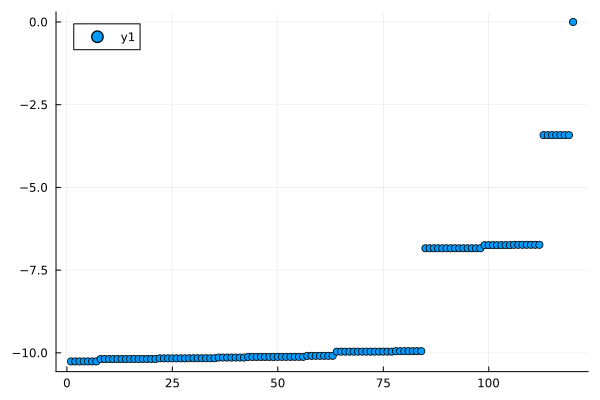

In [35]:
scatter(EEA[5,3,:])

In [36]:
#bands = [[1,3],[4,6],[7,9]]
bands = [[1,7]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

1-element Vector{Any}:
 1.0000000000000007 + 2.451902024746528e-16im

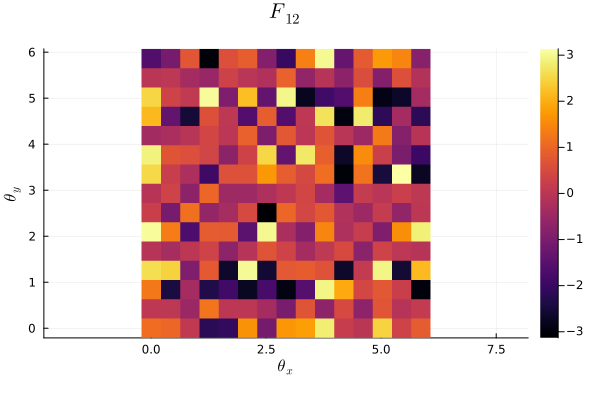

In [38]:
heatmap(Tx, Ty, imag(F12list), title=L"F_{12}", xlabel=L"\theta_x",ylabel=L"\theta_y",aspect_ratio=1)
# Filtreleme yapmadığım için F12 böyle görülüyor olabilir.

In [102]:
param_dict["θθ"] = [0, 0];

In [27]:
H_T = get_Hofstadter_hamiltonian(param_dict);
H1 = get_sp_op(basis, H_T);
sub_states = get_subset_states(H1, param_dict["sub_range"])

subspace_proj, P, Pt = get_projector_op(basis, sub_states);
param_dict["projection"] = subspace_proj, P, Pt;

get_H_mb(param_dict)

Operator(dim=45x45)
  basis: ManyBody(onebodybasis=NLevel(N=9), states:45)sparse([1, 2, 3, 1, 2, 3, 10, 11, 1, 2  …  21, 7, 15, 22, 8, 16, 23, 9, 17, 24], [1, 1, 1, 2, 2, 2, 2, 2, 3, 3  …  21, 22, 22, 22, 23, 23, 23, 24, 24, 24], ComplexF64[-5.448709963501725 + 0.0im, 4.4e-16 + 0.0im, -6.0e-17 + 1.2e-16im, 4.4e-16 + 0.0im, -5.448709963501723 + 0.0im, 4.0e-17 + 9.0e-17im, 4.4e-16 + 0.0im, -4.0e-17 + 8.0e-17im, -6.0e-17 - 1.2e-16im, 4.0e-17 - 9.0e-17im  …  -2.724354981750859 + 0.0im, -4.0e-17 - 8.0e-17im, 4.0e-17 - 9.0e-17im, -2.724354981750859 + 0.0im, -4.0e-17 - 8.0e-17im, 4.0e-17 - 9.0e-17im, -2.724354981750859 + 0.0im, -4.0e-17 - 8.0e-17im, 4.0e-17 - 9.0e-17im, -2.724354981750859 + 0.0im], 45, 45)

In [104]:
PN = 2
param_dict["PN"] = PN
basis_mb_chern = get_basis_mb(param_dict);
param_dict["basis_mb"] = basis_mb_chern

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), states:3), states:6)

In [105]:
param_dict["dimH_mb"] = length(basis_mb_chern)

6

In [106]:
param_dict["θθ"] = [0, 1.1];

In [107]:
H_mb_Chern_basis = get_H_mb(param_dict); 

In [108]:
# #H_T = get_Hofstadter_hamiltonian(param_dict);

# H1 = get_sp_op(basis, H_T);
# sub_states = get_subset_states(H1, param_dict["sub_range"])
# subspace_proj, P, Pt = get_projector_op(basis, sub_states);
# param_dict["projection"] = subspace_proj, P, Pt;

basis_mb_1 = get_basis_mb(param_dict);

In [109]:
H_mb_1 = get_H_mb(param_dict);

In [110]:
H_mb_Chern_basis == H_mb_1

true

In [111]:
basis_mb_1

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), states:3), states:6)

In [112]:
basis_mb_chern

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), states:3), states:6)

In [113]:
U = get_mb_op(basis_mb_chern, P);
U

Operator(dim=6x6)
  basis: ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), states:3), states:6)sparse([1, 2, 3, 1, 2, 3, 4, 5, 1, 2  …  4, 5, 2, 3, 4, 5, 6, 3, 5, 6], [1, 1, 1, 2, 2, 2, 2, 2, 3, 3  …  4, 4, 5, 5, 5, 5, 5, 6, 6, 6], ComplexF64[-0.23829244179720815 + 1.0143116485190087im, 0.07471462268067121 + 0.1294095225512606im, -0.3018546800913304 - 0.10205692203302481im, -0.29731743702232843 + 0.6709529134395199im, -0.06631500454730721 + 0.4156494733133944im, 0.07879241070598719 + 0.21603889570766988im, 0.07471462268067121 + 0.1294095225512606im, -0.21344349122547565 - 0.07216514163657863im, -0.1874377184233606 + 0.5552600960652501im, 0.39433756729740654 - 2.0e-17im  …  0.1056624327025937 - 0.18301270189221971im, 0.11142929583247815 + 0.30552513630989336im, -0.13253848174729294 + 0.39262817925003207im, -0.21023517588349272 + 0.47443535494995515im, 0.5576775358252055 - 2.0e-17im, 0.109035499375374 - 0.1458106660230292im, 0.11142929583247815 + 0.30552513630989336im, -0.18743771

In [114]:
H_mb_Chern_basis

Operator(dim=6x6)
  basis: ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), states:3), states:6)sparse([1, 2, 3, 1, 2, 3, 4, 5, 1, 2  …  4, 5, 2, 3, 4, 5, 6, 3, 5, 6], [1, 1, 1, 2, 2, 2, 2, 2, 3, 3  …  4, 4, 5, 5, 5, 5, 5, 6, 6, 6], ComplexF64[-4.833656291278133 + 0.0im, -0.00062305468097189 - 0.00314871122431113im, -0.00779650749652046 - 0.00512812914309899im, -0.00062305468097189 + 0.00314871122431113im, -4.85454477037374 + 0.0im, -0.04308390367031367 + 0.04380016379758636im, -0.00062305468097189 - 0.00314871122431113im, -0.00551296332036137 - 0.00362613489188565im, -0.00779650749652046 + 0.00512812914309899im, -0.04308390367031367 - 0.04380016379758636im  …  -4.875433249469348 + 0.0im, -0.06092984089053357 + 0.06194278567670968im, -0.00551296332036137 + 0.00362613489188565im, -0.00044056618996524 + 0.0022264750587086im, -0.06092984089053357 - 0.06194278567670968im, -5.0329226982085595 + 0.0im, -0.06092984089053357 + 0.06194278567670968im, -0.00779650749652046 + 0.0051281291430

## Projected Non-Interacting Many Body

In [115]:
EEA, UUA = calc_all_states_H_mb(param_dict);

In [116]:
#param_dict["model_H1"] = H_mb_Chern_basis;

In [117]:
param_dict

Dict{Any, Any} with 23 entries:
  "pbc"            => true
  "neighbors_list" => [[[1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]]]
  "site_number"    => Dict{Any, Any}([2, 2, 1]=>9, [2, 1, 1]=>6, [1, 0, 1]=>2, …
  "Tx"             => [0.0, 0.314159, 0.628319, 0.942478, 1.25664, 1.5708, 1.88…
  "param_2"        => "Ty"
  "θθ"             => [5.96903, 5.96903]
  "t"              => -1
  "Ty"             => [0.0, 0.314159, 0.628319, 0.942478, 1.25664, 1.5708, 1.88…
  "PN"             => 2
  "model_H1"       => get_Hofstadter_hamiltonian
  "vv_basis"       => [[0, 0]]
  "basis_mb"       => ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=9), st…
  "LL"             => [3, 3]
  "ϕ"              => 0.333333
  "sub_range"      => 1:3
  "basis"          => NLevel(N=9)
  "projection"     => (Subspace(superbasis=NLevel(N=9), states:3), Operator(dim…
  "dimH_mb"        => 6
  "vv_lattice"     => [[1.0, 0.0], [0.0, 1.0]]
  "gauge"          => "Landau"
  "sites"          => Any[[0, 0, 1], [1, 0, 1]

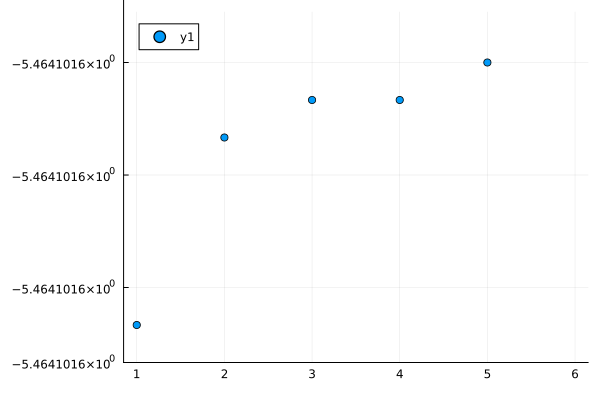

In [118]:
scatter(EEA[1,1,:])#, ylimits=(-6,-4))

### Projected Many Body Chern

In [121]:
#bands = [[1,6], [7,15], [16,21]]
#bands = [[1,3], [4,6]]
#bands = [[1,3]]
bands = [[1,6]]
#bands = [[1,5],[6,10],[11,15]]
#bands = [[1,5]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

1-element Vector{Any}:
 2.2046029658029097e-16 - 1.413579858428226e-16im

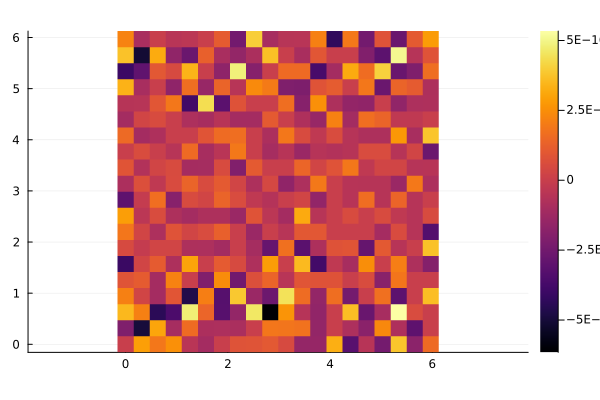

In [123]:
heatmap(Tx,Ty,imag(F12list),aspect_ratio=1)

## Transformed single particle basis

In [124]:
param_dict["sub_range"] = 1:3;

In [125]:
param_dict["θθ"] = [0, 0];

In [126]:
H_T = get_Hofstadter_hamiltonian(param_dict);
H1 = get_sp_op(basis, H_T);
sub_states = get_subset_states(H1, param_dict["sub_range"])

subspace_proj, P, Pt = get_projector_op(basis, sub_states);
param_dict["projection_chern"] = subspace_proj, P, Pt;

In [127]:
PN = 2
param_dict["PN"] = PN
basis_mb_chern = get_basis_mb(param_dict);
param_dict["basis_mb_chern"] = basis_mb_chern
param_dict["dimH_mb"] = length(basis_mb_chern)

6

In [128]:
mb_states_chern = bosonstates(param_dict["projection_chern"][1], param_dict["PN"]);
param_dict["mb_states_chern"] = mb_states_chern

6-element Vector{Vector{Int64}}:
 [2, 0, 0]
 [1, 1, 0]
 [1, 0, 1]
 [0, 2, 0]
 [0, 1, 1]
 [0, 0, 2]

In [129]:
param_dict["θθ"] = [0, 1.1];

In [130]:
H_T = get_Hofstadter_hamiltonian(param_dict);
H1 = get_sp_op(basis, H_T);
sub_states = get_subset_states(H1, param_dict["sub_range"])

subspace_proj, P, Pt = get_projector_op(basis, sub_states);
param_dict["projection"] = subspace_proj, P, Pt;

In [131]:
basis_mb = get_basis_mb(param_dict);
param_dict["basis_mb"] = basis_mb
mb_states = bosonstates(param_dict["projection"][1], param_dict["PN"]);
param_dict["mb_states"] = mb_states

6-element Vector{Vector{Int64}}:
 [2, 0, 0]
 [1, 1, 0]
 [1, 0, 1]
 [0, 2, 0]
 [0, 1, 1]
 [0, 0, 2]

In [132]:
param_dict["projection_chern"][2]*param_dict["projection"][2]'

Operator(dim=3x3)
  basis left:  Subspace(superbasis=NLevel(N=9), states:3)
  basis right: Subspace(superbasis=NLevel(N=9), states:3)
   0.671778+0.609258im    0.188834-0.0431921im     0.209173-0.169895im
   -0.13417-0.139419im    0.933827-0.167325im    -0.0151595+0.0305664im
 -0.0987628-0.258509im  -0.0187952-0.00529495im    0.931108-0.20006im

In [133]:
param_dict["projection"][2]*param_dict["projection_chern"][2]'

Operator(dim=3x3)
  basis left:  Subspace(superbasis=NLevel(N=9), states:3)
  basis right: Subspace(superbasis=NLevel(N=9), states:3)
 0.671778-0.609258im     -0.13417+0.139419im   -0.0987628+0.258509im
 0.188834+0.0431921im    0.933827+0.167325im   -0.0187952+0.00529495im
 0.209173+0.169895im   -0.0151595-0.0305664im    0.931108+0.20006im

In [134]:
get_state_list(mb_states_chern)

(Any[Any[1, 1], Any[1, 2], Any[1, 3], Any[2, 2], Any[2, 3], Any[3, 3]], Any[0.7071067811865475, 1.0, 1.0, 0.7071067811865475, 1.0, 0.7071067811865475])

In [135]:
EEA, UUA = calc_all_states_H_mb_2(param_dict);

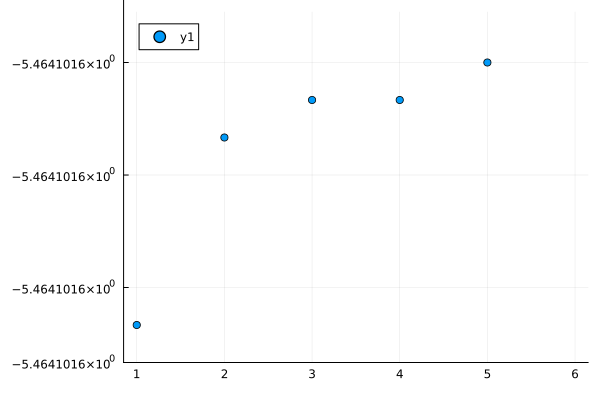

In [136]:
scatter(EEA[1,1,:])#, ylimits=(-6,-4))

In [137]:
bands = [[1,6]]
#bands = [[1,5],[6,10],[11,15]]
#bands = [[1,5]]
Chern, F12list = calc_chern_bands(UUA, bands);
Chern

1-element Vector{Any}:
 0.9999999999999999 - 3.175032886486898e-18im